In [119]:
#importing the relevant libraries
import pandas as pd
import numpy as np
import os
from glob import glob
import sys
pd.set_option('display.max_columns', None, 'display.max_rows', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('max_colwidth',-1)

In [120]:
dta = pd.read_csv('./sampledata/Test/Bejing/Race/Analysis_Race.CSV', sep=";", encoding = "ISO-8859-1")
dtc = pd.read_csv('./sampledata/Test/Bejing/Race/Classification_Race.CSV', sep=";", encoding = "ISO-8859-1")
dtc['DRIVER_NAME'] = dtc['DRIVER_FIRSTNAME'] + " " + dtc['DRIVER_SECONDNAME']
new_test = dta.merge(dtc, on="DRIVER_NAME")
new_test = new_test.rename(columns=lambda x: x.strip())

In [121]:
new_test = new_test.drop(columns = ['DRIVER_NUMBER', 'LAPS', 'FL_KPH', 'HOUR', 'TOTAL_TIME',
       'NUMBER', 'DRIVER_SHORTNAME', 'S2_LARGE',
       'FL_LAPNUM', 'VEHICLE',
       'LAP_IMPROVEMENT', 'CLASS', 'S2_IMPROVEMENT', 'TOP_SPEED',
       'DRIVER_COUNTRY', 'STATUS', 'ELAPSED', 'ï»¿POSITION', 'TIRES',
       'S3_LARGE', 'GAP_PREVIOUS', 'ï»¿NUMBER',
       'GAP_FIRST', 'DIVISION', 'DRIVER_SECONDNAME', 'DRIVER_FIRSTNAME',
       'LAP_TIME', 'S1_IMPROVEMENT', 'DRIVER_HOMETOWN', 'FL_TIME',
       'S1_LARGE', 'DRIVER_LICENSE', 'S3_IMPROVEMENT', 'Unnamed: 21', 'Unnamed: 22'])
len(new_test.keys())

10

In [122]:
new_test['location'] = 'Bejing'
# new_test['match_type'] = 'Race'

In [123]:
len(new_test.keys())

11

In [124]:
import math

for i in (['S1', 'S2', 'S3', 'PIT_TIME']):
    p = new_test[i]
    for count, j in enumerate(p):
        x = len(str(j).split(':'))
        if (pd.isna(j)):
            p[count] = "00:00:00"
        elif (x == 1):
            p[count] = "00:00:" + str(j)
        elif (x == 2):
            p[count] = "00:" + str(j)
        elif (x == 3):
            p[count] = "" + str(j)
        p[count] = float(p[count].split(":")[0])*3600000 + float(p[count].split(":")[1])*60000 + float(p[count].split(":")[2])*1000
    new_test[i] = p
    
new_test[['KPH', 'S1', 'S2', 'S3', 'LAP_NUMBER', 'PIT_TIME']] = new_test[['KPH', 'S1', 'S2', 'S3', 'LAP_NUMBER', 'PIT_TIME']].apply(pd.to_numeric)

<ipython-input-124-c6a8297bc89c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[count] = "00:" + str(j)
<ipython-input-124-c6a8297bc89c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[count] = float(p[count].split(":")[0])*3600000 + float(p[count].split(":")[1])*60000 + float(p[count].split(":")[2])*1000
<ipython-input-124-c6a8297bc89c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[count] = "00:00:" + str(j)
<ipython-in

In [125]:
new_test.shape

(431, 11)

In [126]:
new_test[['GROUP']] = new_test[['GROUP']].fillna(0)
# new_test[['CROSSING_FINISH_LINE_IN_PIT']] = new_test[['CROSSING_FINISH_LINE_IN_PIT']].fillna('')
# new_test['GROUP'] = new_test['GROUP'].replace({'A':0,'B':0})

In [127]:
new_test.head(3)

,LAP_NUMBER,CROSSING_FINISH_LINE_IN_PIT,S1,S2,S3,KPH,DRIVER_NAME,PIT_TIME,TEAM,GROUP,location
0,1,NaN,2295917.0,37598.0,36688.0,5.2,Jarno Trulli,2259620.0,Trulli Formula E Team,1,Bejing
1,2,NaN,39052.0,35808.0,37736.0,110.4,Jarno Trulli,0.0,Trulli Formula E Team,1,Bejing
2,1,NaN,42306.0,36207.0,35301.0,109.2,Lucas di Grassi,0.0,Audi Sport ABT Formula E Team,3,Bejing


In [128]:
set(new_test['DRIVER_NAME']), max(new_test['LAP_NUMBER'])

({'Charles Pic',
  'Daniel Abt',
  'Franck Montagny',
  'Ho-Pin Tung',
  'Jaime Alguersuari',
  'Jarno Trulli',
  "JÃ©rome d'AmbrosioÂ\xa0",
  'Karun Chandhok',
  'Katherine Legge',
  'Lucas di Grassi',
  'Michela Cerruti',
  'Nelson Piquet JR',
  'Nick Heidfeld',
  'Nicolas Prost',
  'Oriol Servia',
  'Sam Bird',
  'Sebastien Buemi',
  'Stephane Sarrazin',
  'Takuma Sato'},
 25)

In [129]:
Drivers = list(set(new_test['DRIVER_NAME']))
Max_Laps = max(new_test['LAP_NUMBER'])

In [130]:
from sklearn import ensemble, linear_model, neighbors, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import joblib

def encode_column_to_dataframe(df, allcols):
    '''Takes the column name as a string and adds to the dataframe'''
    for col in allcols:
        #dum_df = pd.get_dummies(df, columns=col, prefix=col)
        # creating instance of one-hot-encoder
        enc = OneHotEncoder(handle_unknown='ignore')
        # passing bridge-types-cat column (label encoded values of bridge_types)
        enc_df = pd.DataFrame(enc.fit_transform(df[[col]]).toarray())
        # merge with main df bridge_df on key values
        df = df.join(enc_df.add_prefix(col+"_"))
    return df
def get_encoded_dataframe(final):
    final_data = encode_column_to_dataframe(final,['DRIVER_NAME','location','match_type','TEAM'])
    final_data.drop(columns = ['DRIVER_NAME','location','match_type','TEAM'],inplace = True)
    #final_copy.to_csv('./cleaned/final_processed_before_ml.csv')
    #drop only if that column exists originally
    #final_data.drop(columns = ['Unnamed: 0'],inplace = True)
    return final_data
def get_encoded_dataframe_1(final):
    for i in ['DRIVER_NAME','location','TEAM']:
        final[i] = final[i].astype('category').cat.codes
    normalized_df=(final-final.mean())/final.std()
    return normalized_df

In [215]:
dr = pd.read_csv('./cleaned_train/race_train_final_processed1.csv')
dr.shape

(1305, 30)

In [216]:
aggregation = {'KPH':[('mean_KPH','mean'),
                ('std_KPH','std'),
                ('med_KPH','median'),
                ('max_KPH','max'),
                ('min_KPH','min'),
                ('skew_KPH','skew')],
              'S1' : [('mean_S1','mean'),
                ('std_S1','std'),
                ('med_S1','median'),
                ('max_S1','max'),
                ('min_S1','min'),
                ('skew_S1','skew')],
              'S2' : [('mean_S2','mean'),
                ('std_S2','std'),
                ('med_S2','median'),
                ('max_S2','max'),
                ('min_S2','min'),
                ('skew_S2','skew')],
              'S3' : [('mean_S3','mean'),
                ('std_S3','std'),
                ('med_S3','median'),
                ('max_S3','max'),
                ('min_S3','min'),
                ('skew_S3','skew')],
               'LAP_NUMBER': [('Total_Lap_Num','max')],
#                'PIT_TIME': [('PIT_TIME_sum','sum')],
               'CROSSING_FINISH_LINE_IN_PIT': [('cnt_CROSSING_FINISH_LINE_IN_PIT','count')],
              }

Max_At_Each_Lap = dict((val, []) for val in Drivers)

models = {
    "ElasticNet": linear_model.ElasticNet(random_state=0, max_iter=10000),
    "Random Forest": ensemble.RandomForestRegressor(n_estimators=100),
    "K-Nearest Neighbors": neighbors.KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', weights='distance'),
}

for i in Drivers:
    for j in range(1,Max_Laps):
        print(i,j)
        if any((new_test['DRIVER_NAME'] == i) & (new_test['LAP_NUMBER'] >= j)):
            temp = new_test[(new_test['DRIVER_NAME'] == i) & (new_test['LAP_NUMBER'] <= j)]
            df = temp.groupby(['DRIVER_NAME', 'location','GROUP','TEAM'], as_index=True).agg(aggregation).reset_index()            
            df.columns = df.columns.droplevel()
            column_names = df.columns.values
            column_names[:4] = ['DRIVER_NAME','location','GROUP','TEAM']
            df.columns = column_names
            df = df.fillna(0)
            df = pd.concat([dr,df])
            for i1 in ['DRIVER_NAME','location','TEAM']:
                df[i1] = df[i1].astype('category').cat.codes
            final_df = df
            y = final_df['Total_Lap_Num'].to_numpy()
            X = final_df.drop(columns = ['Total_Lap_Num']).to_numpy()
            X = (X-X.mean())/X.std()
            sum_lap = []
            for k in models.keys():
                model = models[k].fit(X[:1305],y[:1305])
                sum_lap.append(model.predict(X[1305:])[0])
            Max_At_Each_Lap[i].append(sum_lap) 

Oriol Servia 1
Oriol Servia 2
Oriol Servia 3
Oriol Servia 4
Oriol Servia 5
Oriol Servia 6
Oriol Servia 7
Oriol Servia 8
Oriol Servia 9
Oriol Servia 10
Oriol Servia 11
Oriol Servia 12
Oriol Servia 13
Oriol Servia 14
Oriol Servia 15
Oriol Servia 16
Oriol Servia 17
Oriol Servia 18
Oriol Servia 19
Oriol Servia 20
Oriol Servia 21
Oriol Servia 22
Oriol Servia 23
Oriol Servia 24
Jaime Alguersuari 1
Jaime Alguersuari 2
Jaime Alguersuari 3
Jaime Alguersuari 4
Jaime Alguersuari 5
Jaime Alguersuari 6
Jaime Alguersuari 7
Jaime Alguersuari 8
Jaime Alguersuari 9
Jaime Alguersuari 10
Jaime Alguersuari 11
Jaime Alguersuari 12
Jaime Alguersuari 13
Jaime Alguersuari 14
Jaime Alguersuari 15
Jaime Alguersuari 16
Jaime Alguersuari 17
Jaime Alguersuari 18
Jaime Alguersuari 19
Jaime Alguersuari 20
Jaime Alguersuari 21
Jaime Alguersuari 22
Jaime Alguersuari 23
Jaime Alguersuari 24
Stephane Sarrazin 1
Stephane Sarrazin 2
Stephane Sarrazin 3
Stephane Sarrazin 4
Stephane Sarrazin 5
Stephane Sarrazin 6
Stephane S

In [118]:
Max_At_Each_Lap

{'Oriol Servia': [[22.008558185055485, 2.5, 2.7880515114930695]],
 'Jaime Alguersuari': [[22.025345493255873, 2.65, 2.7939158411258487]],
 'Stephane Sarrazin': [[21.989344825267597, 2.27, 2.783493204529914]],
 'Nelson Piquet JR': [[22.009937659915174, 2.54, 2.786370202075397]],
 'Sam Bird': [[22.017552394336974, 2.39, 2.7899652837439044]],
 'Daniel Abt': [[22.030466198185085, 2.51, 2.795188599653662]],
 'Michela Cerruti': [[21.988862364018424, 2.72, 2.7923020302374093]],
 'Charles Pic': [[22.01235926883358, 2.31, 2.78703816655824]],
 'Karun Chandhok': [[22.02678517433252, 2.61, 2.7933636048960473]],
 'Sebastien Buemi': [[21.993678273866966, 2.42, 2.792853687753525]],
 'Katherine Legge': [[22.005804378565152, 2.43, 2.7962071404402664]],
 "JÃ©rome d'AmbrosioÂ\xa0": [[22.000089190036455, 2.61, 2.786965166600606]],
 'Nicolas Prost': [[22.042069598763646, 2.47, 2.806954807623325]],
 'Lucas di Grassi': [[22.03679161344956, 2.51, 2.801599562240993]],
 'Franck Montagny': [[22.02145022912077, 2

In [217]:
temp = new_test
aggregation = {'KPH':[('mean_KPH','mean'),
                ('std_KPH','std'),
                ('med_KPH','median'),
                ('max_KPH','max'),
                ('min_KPH','min'),
                ('skew_KPH','skew')],
              'S1' : [('mean_S1','mean'),
                ('std_S1','std'),
                ('med_S1','median'),
                ('max_S1','max'),
                ('min_S1','min'),
                ('skew_S1','skew')],
              'S2' : [('mean_S2','mean'),
                ('std_S2','std'),
                ('med_S2','median'),
                ('max_S2','max'),
                ('min_S2','min'),
                ('skew_S2','skew')],
              'S3' : [('mean_S3','mean'),
                ('std_S3','std'),
                ('med_S3','median'),
                ('max_S3','max'),
                ('min_S3','min'),
                ('skew_S3','skew')],
               'LAP_NUMBER': [('Total_Lap_Num','max')],
#                'PIT_TIME': [('PIT_TIME_sum','sum')],
               'CROSSING_FINISH_LINE_IN_PIT': [('cnt_CROSSING_FINISH_LINE_IN_PIT','count')],
              }

temp['match_key'] = temp['DRIVER_NAME'] + temp['location']
df = temp.groupby(['match_key','DRIVER_NAME','location','GROUP','TEAM'], as_index=True).agg(aggregation).reset_index()
df.columns = df.columns.droplevel()
column_names = df.columns.values
column_names[:5] = ['match_key','DRIVER_NAME','location','GROUP', 'TEAM']
df.columns = column_names
df = df.drop(columns = ['match_key'])
df = df.fillna(0)
# df.to_csv('./cleaned_train/race_train_final_processed1.csv',index = False)
df.shape

(19, 30)

In [218]:
from sklearn.preprocessing import OneHotEncoder

def encode_column_to_dataframe(df, allcols):
    '''Takes the column name as a string and adds to the dataframe'''
    for col in allcols:
        #dum_df = pd.get_dummies(df, columns=col, prefix=col)
        # creating instance of one-hot-encoder
        enc = OneHotEncoder(handle_unknown='ignore')
        # passing bridge-types-cat column (label encoded values of bridge_types)
        enc_df = pd.DataFrame(enc.fit_transform(df[[col]]).toarray())
        # merge with main df bridge_df on key values
        df = df.join(enc_df.add_prefix(col+"_"))
    return df
def get_encoded_dataframe(final):
    final_data = encode_column_to_dataframe(final,['DRIVER_NAME','location','TEAM'])
    final_data.drop(columns = ['DRIVER_NAME','location','TEAM'],inplace = True)
    #final_copy.to_csv('./cleaned/final_processed_before_ml.csv')
    #drop only if that column exists originally
    #final_data.drop(columns = ['Unnamed: 0'],inplace = True)
    return final_data
#Generating model-ready data using one hot encoding

df = pd.concat([dr,df])
print(df.shape)
for i in ['DRIVER_NAME','location','TEAM']:
    df[i] = df[i].astype('category').cat.codes
# final_df = get_encoded_dataframe(df)
final_df = df
y = final_df['Total_Lap_Num'].to_numpy()
X = final_df.drop(columns = ['Total_Lap_Num']).to_numpy()
X = (X-X.mean())/X.std()

(1324, 30)


In [219]:
from sklearn import ensemble, linear_model, neighbors, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

def test_model(X, y, model_name, model):
    print("MODEL: {}".format(model_name))
    model.fit(X[:1305], y[:1305])
    Z = model.predict(X[1305:])
    print(X.shape)
    print(Z)
    print(y[1305:])
    #filename = model_name + '.joblib.pkl'
    #_ = joblib.dump(model, filename, compress=9)
    #print(Z)
    print("R2 Value: ", r2_score(Z, y[1305:]))
    print("MSE Value: ", mean_squared_error(Z, y[1305:]))
    
models = {
    "ElasticNet": linear_model.ElasticNet(random_state=0, max_iter=10000),
    "Random Forest": ensemble.RandomForestRegressor(n_estimators=100),
    "K-Nearest Neighbors": neighbors.KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', weights='distance'),
}
for model in models.keys():
    print('----------------------\n')
    test_model(X,y,model, models[model])
    

----------------------

MODEL: ElasticNet
(1324, 29)
[22.98287707 23.02130008 22.96946084 23.92273043 23.10824152 -4.27073457
 22.95513053 22.99472699 23.01574688 22.98151465 22.85903448 22.91134942
 22.95017144 22.94643423 22.9116063  22.98073119 24.28463387 22.91845958
 23.63945201]
[25. 25. 25. 23. 25.  2. 25. 25. 24. 25. 24. 25. 24. 24. 25. 25. 14. 25.
 21.]
R2 Value:  0.7163918543380825
MSE Value:  10.657553682014798
----------------------

MODEL: Random Forest
(1324, 29)
[27.11 27.17 27.31 27.09 27.36  2.05 27.41 27.12 27.37 27.25 21.2  27.33
 27.19 27.15 27.43 27.15 17.76 27.55 19.16]
[25. 25. 25. 23. 25.  2. 25. 25. 24. 25. 24. 25. 24. 24. 25. 25. 14. 25.
 21.]
R2 Value:  0.8130739680044743
MSE Value:  6.917884210526317
----------------------

MODEL: K-Nearest Neighbors
(1324, 29)
[29.         29.         29.         25.43847107 29.          2.30024714
 29.         29.         29.         29.         29.         29.
 29.         29.         29.         29.         28.0046193  2

In [229]:
sorted(Drivers)

['Charles Pic',
 'Daniel Abt',
 'Franck Montagny',
 'Ho-Pin Tung',
 'Jaime Alguersuari',
 'Jarno Trulli',
 "JÃ©rome d'AmbrosioÂ\xa0",
 'Karun Chandhok',
 'Katherine Legge',
 'Lucas di Grassi',
 'Michela Cerruti',
 'Nelson Piquet JR',
 'Nick Heidfeld',
 'Nicolas Prost',
 'Oriol Servia',
 'Sam Bird',
 'Sebastien Buemi',
 'Stephane Sarrazin',
 'Takuma Sato']

In [174]:
import statistics

Max_RF = []
Max_KNN = []
Max_EN = []
Avg = []
Maxie = []
Median = []

In [234]:
import statistics

Max_RF = []
Max_KNN = []
Max_EN = []
W_Avg = []
Maxie = []
Mean = []

for j in range(0,Max_Laps-1):
    m_r = 0
    m_k = 0
    m_e = 0
    for i in Drivers:
        if j>len(Max_At_Each_Lap[i])-1:
            continue
        temp = Max_At_Each_Lap[i][j]
        if temp[0] > m_e:
            m_e = abs(temp[0])
        if temp[1] > m_r:
            m_r = abs(temp[1])
        if temp[2] > m_k:
            m_k = abs(temp[2])
    Max_RF.append(m_r)
    Max_KNN.append(m_k)
    Max_EN.append(m_e)
    if j < 12:
        W_Avg.append((0.05*m_r) + (0.9*m_e) + (0.05*m_k))
    else:
        W_Avg.append((0.5*m_r) + (0.4*m_e) + (0.1*m_k))
    Maxie.append(max([m_r, m_e, m_k]))
    Mean.append(statistics.mean([m_r, m_e, m_k]))

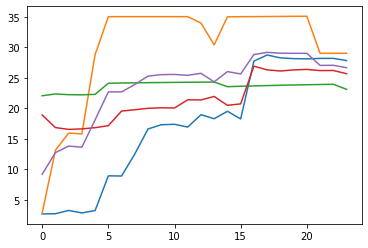

In [235]:
import matplotlib.pyplot as plt
plt.plot(Max_RF)
# plt.clf()
plt.plot(Max_KNN)
plt.plot(Max_EN)
plt.plot(Avg)
plt.plot(Mean)

In [186]:
Max_KNN

[2.800848804154286,
 3.1777276401355348,
 3.0000000000000004,
 3.191753962900363,
 3.1995747573547133,
 3.9818816701983075,
 20.430718835387296,
 22.174790960242973,
 22.219641634662935,
 22.259121460831004,
 22.295494394726017,
 48.60052763955342,
 48.60055290821747,
 48.600520056719546,
 35.10436987779313,
 35.16287048961344,
 35.21645617130313,
 35.26531464941788,
 35.310569589164984,
 35.450675848845144,
 35.451806245922505,
 35.45457111020092,
 35.45700922294118,
 35.45858606494356]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sum_lap = []
for k in models.keys():
    model = models[k].fit(X_train,y_train)
    sum_lap.append(model.predict(X[1305:]))
F = list(zip(sum_lap[0], sum_lap[1], sum_lap[2]))

import numpy as np
from scipy.optimize import nnls 
##Define the input vectors

##Caluculate nnls
x, resdiual_norm = nnls(F,y[1305:])


##Find the difference
print(np.sum(np.sum(F*x,1)-y[1305:]))
x

0.013480790106567664


array([0.        , 0.02039061, 0.97932722])

In [202]:
Max_At_Each_Lap[i], i

([[18.414207651012582, 2.78, 2.2004622386122126],
  [17.347330690965336, 2.15, 2.597274649096954],
  [17.823696167635692, 2.69, 3.0],
  [18.123633281135152, 2.84, 3.191753962900363],
  [18.32777167336396, 3.0, 3.1995747573547133],
  [18.476391533857026, 5.27, 3.2065168797954255],
  [18.590263197524173, 8.43, 3.3910450281911526],
  [18.680834501068993, 10.8, 3.3967374585839414],
  [18.75487451479016, 14.5, 3.4013150848125204],
  [18.816864448088285, 15.13, 3.4050524583947115],
  [18.869671109225337, 15.88, 3.408043249667184],
  [18.968389363123404, 16.3, 3.431846272820306],
  [20.153865541113056, 15.97, 15.936283605966588],
  [20.189248129132796, 17.98, 16.152477475906075],
  [20.22083909654083, 17.14, 16.346596625936805],
  [20.24928091783656, 17.56, 16.523362620023395],
  [20.27504516014656, 16.25, 16.682024758643458],
  [20.29849442065713, 17.93, 16.824577557483135],
  [20.320006511418743, 18.83, 16.955880350449007],
  [20.339795326648357, 20.17, 20.869717334908977],
  [20.3580827933

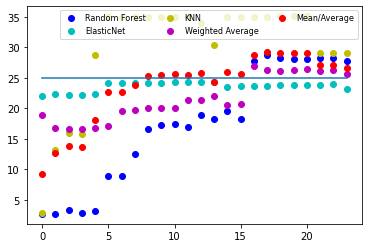

In [226]:
colors = ['b', 'c', 'y', 'm', 'r']

ll = plt.scatter(range(Max_Laps-1), Max_RF, marker='o', color=colors[0])
l  = plt.scatter(range(Max_Laps-1), Max_EN, marker='o', color=colors[1])
a  = plt.scatter(range(Max_Laps-1), Max_KNN, marker='o', color=colors[2])
h  = plt.scatter(range(Max_Laps-1), Avg, marker='o', color=colors[3])
h1  = plt.scatter(range(Max_Laps-1), Mean, marker='o', color=colors[4])
plt.plot([Max_Laps]*(Max_Laps-1))

plt.legend((ll, l, a, h, h1),
           ('Random Forest', 'ElasticNet', 'KNN', 'Weighted Average', 'Mean/Average'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)

In [239]:
WN_Avg = []
for j,i in enumerate(Max_At_Each_Lap['Sam Bird']):
    if j < 12:
        WN_Avg.append((0.05*m_r) + (0.9*m_e) + (0.05*m_k))
    else:
        WN_Avg.append((0.5*m_r) + (0.4*m_e) + (0.1*m_k))

By_Driver = {}
for k in models.keys():
    model = models[k].fit(X[:1305],y[:1305])
    By_Driver[k] = abs(model.predict(X[1305:]))

In [240]:
temp_dict = {'Random Forest':Max_RF, 'ElasticNet':Max_EN, 'KNN':Max_KNN, 'Weighted Average':W_Avg, 'Mean/Average':Mean, 'Actual':[Max_Laps]*(Max_Laps-1)}
D_temp_dict = {'Weighted Average':WN_Avg}
By_Driver['Driver'] = sorted(Drivers)
By_Driver['Actual'] = y[1305:]

In [241]:
df = pd.DataFrame(temp_dict)
df.to_csv('temp_dict.csv')
df = pd.DataFrame(D_temp_dict)
df.to_csv('D_temp_dict.csv')
df = pd.DataFrame(By_Driver)
df.to_csv('By_Driver.csv')